In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ssbc import generate_rigorous_pac_report
import ssbc

In [2]:
p_class1 = 0.10
beta_params_class0 = (2, 7)
beta_params_class1 = (3, 2)

alpha_0 = 0.10
delta_0 = 0.10
alpha_1 = 0.10
delta_1 = 0.10

N_samples = 500

In [3]:
sim = ssbc.BinaryClassifierSimulator(
    p_class1=p_class1, beta_params_class0=beta_params_class0, beta_params_class1=beta_params_class1
)

In [4]:
labels, probs = sim.generate(N_samples)
class_data = ssbc.split_by_class(labels=labels, probs=probs)

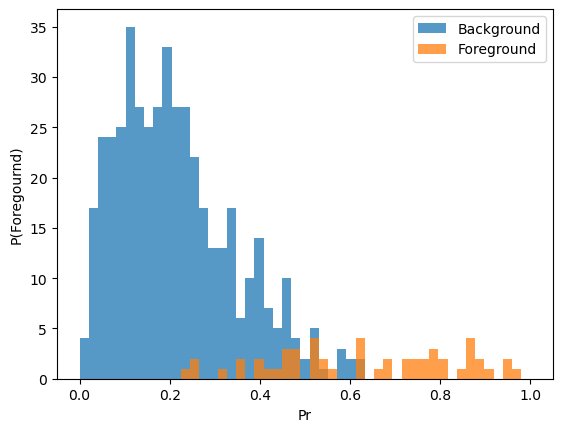

In [5]:
plt.hist(class_data[0]["probs"][:, 1], bins=np.linspace(0, 1, 50), alpha=0.75)
plt.hist(class_data[1]["probs"][:, 1], bins=np.linspace(0, 1, 50), alpha=0.75)
plt.legend(["Background", "Foreground"])
plt.ylabel("P(Foregournd)")
plt.xlabel("Pr")
plt.savefig("tst.png")
plt.show()

In [6]:

# Generate report (now using SIMPLIFIED bounds)
report = generate_rigorous_pac_report(
    labels=labels,
    probs=probs,
    alpha_target=0.10,
    delta=0.10,
    test_size=N_samples,
    ci_level=0.95,
    use_union_bound=False,
    prediction_method="all",
    n_jobs=-1,
    verbose=True,
    loo_inflation_factor=None,
    use_loo_correction=True
    
)

OPERATIONAL PAC-CONTROLLED CONFORMAL PREDICTION REPORT

Parameters:
  Test size: 500
  CI level: 95% (Clopper-Pearson)
  PAC guarantee levels:
    Class 0: δ = 0.10 (90% confidence)
    Class 1: δ = 0.10 (90% confidence)
    Union bound: not applied (metrics validated independently)
    Class guarantees: validated separately

CLASS 0 (Conditioned on True Label = 0)
  Calibration size: n = 448
  Target miscoverage: α = 0.100
  SSBC-corrected α:   α' = 0.0824
  PAC risk:           δ = 0.100
  Conformal threshold: 0.4164

  Calibration summary (n = 448)
     Empirical rates on calibration data. Intervals are 95% Clopper-Pearson.
     These do not include PAC guarantees.
     Abstentions:               0 /  448  =  0.00%   95% CI: [0.000, 0.008]
     Singletons:            346 /  448  = 77.23%   95% CI: [0.731, 0.810]
       Correct:             310 /  448  = 69.20%   95% CI: [0.647, 0.734]
       Incorrect:             36 /  448  =  8.04%   95% CI: [0.057, 0.110]
     Error | singleton:  

In [7]:
validation = ssbc.validate_pac_bounds(
    report=report,
    simulator=sim,
    test_size=N_samples,      # Size of each test set
    n_trials=10000,       # Number of independent trials (increase for better stats)
    seed=42,             # For reproducibility
    verbose=True,
    n_jobs=-1,           # Use all CPU cores
)

ssbc.print_validation_results(validation)


Using fixed thresholds: q̂₀=0.4164, q̂₁=0.7398
Running 10000 trials with test_size=500...
Using all available CPU cores for parallel execution
PREDICTION INTERVAL VALIDATION RESULTS
PAC BOUNDS VALIDATION RESULTS

Trials: 10000
Test size: 500
Thresholds: q̂₀=0.4164, q̂₁=0.7398

MARGINAL

SINGLETON:
  Empirical mean: 0.7591
  Expected (LOO): 0.7820
  Quantiles:      [2.5%: 0.722, 5%: 0.726, 25%: 0.746, 50%: 0.760, 75%: 0.772, 95%: 0.790, 97.5%: 0.796]
  Selected bounds: [0.6920, 0.8580]
  Coverage: 100.0% ✅
  Selected coverage: 100.0% ✅
  Method-specific validation:
    Analytical  : [0.7306, 0.8334] (width: 0.1028, coverage: 92.6%) ❌
    Exact       : [0.6920, 0.8580] (width: 0.1660, coverage: 100.0%) ✅
    Hoeffding   : [0.6495, 0.9145] (width: 0.2651, coverage: 100.0%) ✅

DOUBLET:
  Empirical mean: 0.2409
  Expected (LOO): 0.2180
  Quantiles:      [2.5%: 0.204, 5%: 0.210, 25%: 0.228, 50%: 0.240, 75%: 0.254, 95%: 0.274, 97.5%: 0.278]
  Selected bounds: [0.1420, 0.3080]
  Coverage: 100.

In [ ]:
results1 = ssbc.validate_prediction_interval_calibration(
    simulator=sim,
    n_calibration=N_samples,        # Size of each calibration dataset
    BigN=10000,                  # Number of different calibrations to test
    n_trials=1000,             # Test sets per calibration
    test_size=N_samples,
    ci_level=0.95,
    prediction_method="all",  # Compare all methods
    use_loo_correction=True,
    loo_inflation_factor=1.0,
    verbose=False,            # Minimal printouts
    n_jobs=-1,
    seed=0
)
# Print results


In [ ]:
df1 = ssbc.get_calibration_bounds_dataframe(results1)

In [ ]:
from ssbc import validate_prediction_interval_calibration, get_calibration_bounds_dataframe

In [ ]:
from ssbc import (
    validate_prediction_interval_calibration,
    get_calibration_bounds_dataframe,
    plot_calibration_excess,
)
def plotter(this_df):
    # Plot excess for singleton marginal
    this_df_0_single = this_df[(this_df['scope'] == 'class_0') & (this_df['metric'] == 'singleton')]
    plot_calibration_excess(this_df_0_single, scope='class_0', metric='singleton', methods=['analytical', 'exact', 'hoeffding'])
    
    this_df_1_single = this_df[(this_df['scope'] == 'class_1') & (this_df['metric'] == 'singleton')]
    plot_calibration_excess(this_df_1_single, scope='class_1', metric='singleton', methods=['analytical', 'exact', 'hoeffding'])
    
    # Plot excess for singleton marginal
    this_df_0_doublet = this_df[(this_df['scope'] == 'class_0') & (this_df['metric'] == 'doublet')]
    plot_calibration_excess(this_df_0_doublet, scope='class_0', metric='doublet', methods=['analytical', 'exact', 'hoeffding'])
    
    this_df_1_doublet = this_df[(this_df['scope'] == 'class_1') & (this_df['metric'] == 'doublet')]
    plot_calibration_excess(this_df_1_doublet, scope='class_1', metric='doublet', methods=['analytical', 'exact', 'hoeffding'])
    
    this_df_m_single_e = this_df[(this_df['scope'] == 'marginal') & (this_df['metric'] == 'singleton_error_class0')]
    plot_calibration_excess(this_df_m_single_e, scope='marginal', metric='singleton_error_class0', methods=['analytical', 'exact', 'hoeffding'])
    
    this_df_m_single_e = this_df[(this_df['scope'] == 'marginal') & (this_df['metric'] == 'singleton_error_class1')]
    plot_calibration_excess(this_df_m_single_e, scope='marginal', metric='singleton_error_class1', methods=['analytical', 'exact', 'hoeffding'])



In [ ]:
plotter(df1)

In [ ]:
ssbc.print_calibration_validation_results(results1)